<a href="https://colab.research.google.com/github/prapti814/ML/blob/main/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetes-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/diabetes-prediction-dataset


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
import os

# List files in the downloaded directory to find the CSV file
files_in_directory = os.listdir(path)
csv_file = None
for file in files_in_directory:
    if file.endswith(".csv"):
        csv_file = file
        break

if csv_file:
    csv_file_path = os.path.join(path, csv_file)
    try:
        data = pd.read_csv(csv_file_path, encoding='latin1')
        print("DataFrame loaded successfully with latin1 encoding.")
    except Exception as e:
        print(f"Error reading CSV with latin1 encoding: {e}")
        try:
            data = pd.read_csv(csv_file_path, encoding='ISO-8859-1')
            print("DataFrame loaded successfully with ISO-8859-1 encoding.")
        except Exception as e:
            print(f"Error reading CSV with ISO-8859-1 encoding: {e}")
            print("Could not read the CSV file with common encodings.")

else:
    print("No CSV file found in the downloaded directory.")

DataFrame loaded successfully with latin1 encoding.


In [17]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [18]:
data.shape

(100000, 9)

In [21]:
from sklearn.preprocessing import LabelEncoder

In [23]:
le=LabelEncoder()
le.fit(data['gender'])
data['gender']=le.transform(data['gender'])

In [27]:
data.head()
# female=0 male=1

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,0,54.0,0,0,No Info,27.32,6.6,80,0
2,1,28.0,0,0,never,27.32,5.7,158,0
3,0,36.0,0,0,current,23.45,5.0,155,0
4,1,76.0,1,1,current,20.14,4.8,155,0


In [25]:
data["smoking_history"].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [28]:
le.fit(data['smoking_history'])
data['smoking_history']=le.transform(data['smoking_history'])


In [29]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0


In [31]:
data['smoking_history'].value_counts()

,count
smoking_history,
0,35816
4,35095
3,9352
1,9286
5,6447
2,4004


In [32]:
x=data.iloc[:,:-1]
y=data['diabetes']

In [33]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x=pd.DataFrame(sc.fit_transform(x))

In [37]:
x.isnull().sum()

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0


In [48]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [39]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00


In [40]:
import kerastuner as kt

/tmp/ipython-input-1654478174.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [46]:
def build_model(hp):
    model = Sequential()
    counter=0
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
      if counter==0:
        model.add(Dense(units=hp.Int('units_'+str(i),min_value=8,max_value=128,step=8),activation=hp.Choice("activation"+str(i),values=["relu","celu","leaky_relu","elu"]),input_dim=x.shape[1]))
        model.add(Dropout(hp.Choice('dropout_'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
      else:
        model.add(Dense(units=hp.Int('units_'+str(i),min_value=8,max_value=128,step=8),activation=hp.Choice("activation"+str(i),values=["relu","celu","leaky_relu","elu"])))
        model.add(Dropout(hp.Choice('dropout_'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
      counter+=1
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizers',values=['Adam','RMSprop','SGD','Adagrad','Adadelta']),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [47]:
tuner=kt.RandomSearch(build_model,
                      objective='val_accuracy',
                      max_trials=3,
                      directory='my_dir',
                      project_name='diabetes')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
tuner.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Trial 3 Complete [00h 00m 41s]
val_accuracy: 0.9146000146865845

Best val_accuracy So Far: 0.9146000146865845
Total elapsed time: 00h 01m 58s


In [51]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 9,
 'units_0': 128,
 'activation0': 'elu',
 'dropout_0': 0.7,
 'optimizers': 'Adagrad',
 'units_1': 8,
 'activation1': 'relu',
 'dropout_1': 0.1,
 'units_2': 8,
 'activation2': 'relu',
 'dropout_2': 0.1,
 'units_3': 8,
 'activation3': 'relu',
 'dropout_3': 0.1,
 'units_4': 8,
 'activation4': 'relu',
 'dropout_4': 0.1,
 'units_5': 8,
 'activation5': 'relu',
 'dropout_5': 0.1,
 'units_6': 8,
 'activation6': 'relu',
 'dropout_6': 0.1,
 'units_7': 8,
 'activation7': 'relu',
 'dropout_7': 0.1,
 'units_8': 8,
 'activation8': 'relu',
 'dropout_8': 0.1}

In [50]:
model=tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adagrad', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [55]:
history=model.fit(x_train,y_train,epochs=50,initial_epoch=6,batch_size=10000,validation_data=(x_test,y_test),callbacks=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3))

Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9148 - loss: 0.2172 - val_accuracy: 0.9146 - val_loss: 0.1700
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9149 - loss: 0.2178 - val_accuracy: 0.9146 - val_loss: 0.1700
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9148 - loss: 0.2162 - val_accuracy: 0.9146 - val_loss: 0.1700
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9146 - loss: 0.2163 - val_accuracy: 0.9146 - val_loss: 0.1700
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9142 - loss: 0.2176 - val_accuracy: 0.9146 - val_loss: 0.1700
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9141 - loss: 0.2166 - val_accuracy: 0.9146 - val_loss: 0.1699
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9153 - loss: 0.2153 - val_accuracy: 0.9146 - val_loss: 0.1699
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9160 - loss: 0.2167 - val_accuracy: 0.9146 - val_loss: 0.

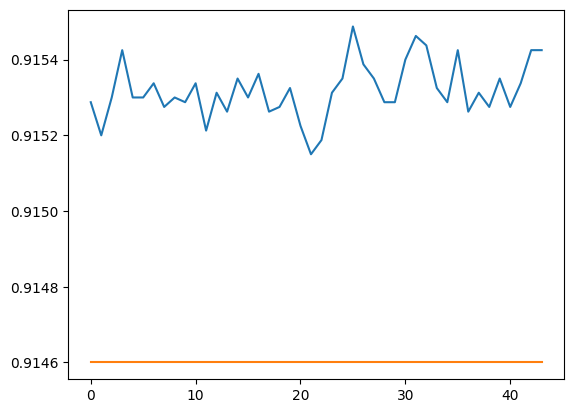

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

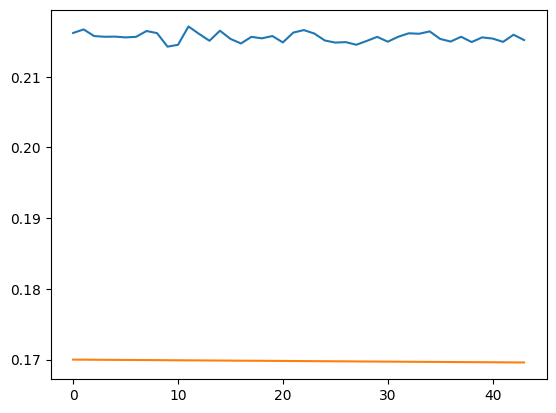

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
from sklearn.

In [59]:
from tensorflow.keras.regularizers import l2
model1=Sequential()
model1.add(Dense(128,activation="relu",input_dim=x.shape[1],kernel_regularizer=l2(0.001)))
Dropout(0.1)
model1.add(Dense(72,activation="celu",kernel_regularizer=l2(0.001)))
Dropout(0.1)
model1.add(Dense(32,activation="relu",kernel_regularizer=l2(0.001)))
Dropout(0.1)
model1.add(Dense(1,activation="sigmoid"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [61]:
history1 = model1.fit(x_train, y_train, epochs=50, batch_size=10000, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8598 - loss: 0.7191 - val_accuracy: 0.9146 - val_loss: 0.5258
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9140 - loss: 0.4900 - val_accuracy: 0.9149 - val_loss: 0.3957
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9208 - loss: 0.3731 - val_accuracy: 0.9427 - val_loss: 0.3259
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9457 - loss: 0.3168 - val_accuracy: 0.9501 - val_loss: 0.2941
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9511 - loss: 0.2892 - val_accuracy: 0.9531 - val_loss: 0.2794
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9531 - loss: 0.2776 - val_accuracy: 0.9536 - val_loss: 0.2701
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9549 - loss: 0.2686 - val_accuracy: 0.9556 - val_loss: 0.2634
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9564 - loss: 0.2619 - val_accuracy: 0.9564 - val_loss: 0.2574


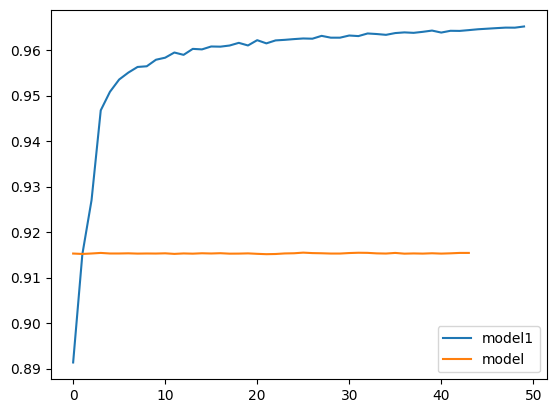

In [65]:
plt.plot(history1.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.legend(['model1','model'])
plt.show()

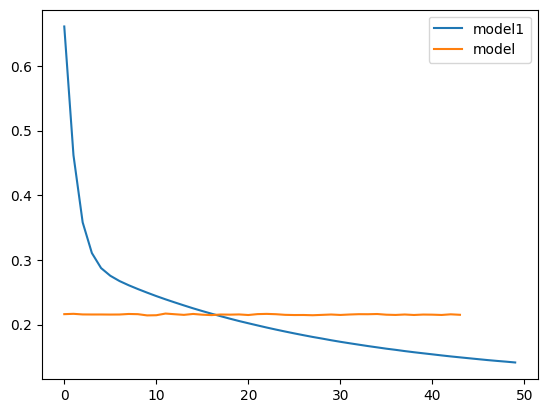

In [66]:
plt.plot(history1.history['loss'])
plt.plot(history.history['loss'])
plt.legend(['model1','model'])
plt.show()

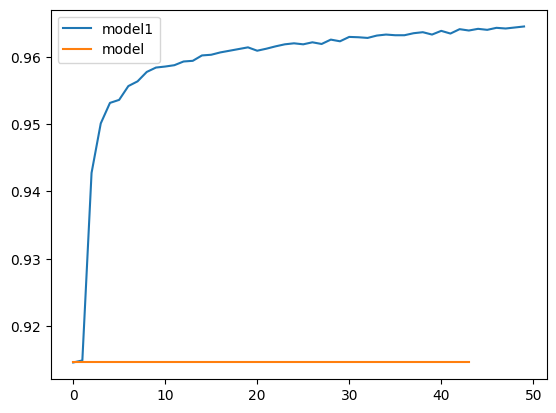

In [67]:
plt.plot(history1.history['val_accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['model1','model'])
plt.show()

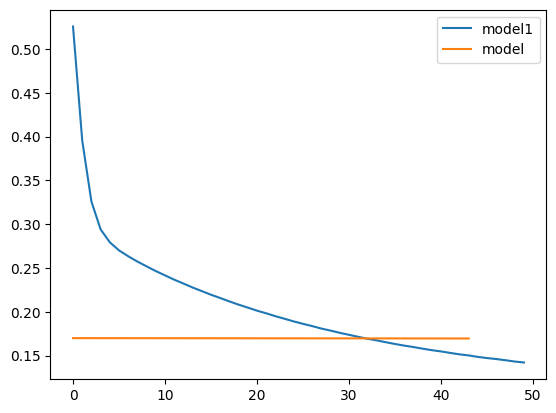

In [68]:
plt.plot(history1.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.legend(['model1','model'])
plt.show()